In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("biaiscience/dogs-vs-cats")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dogs-vs-cats' dataset.
Path to dataset files: /kaggle/input/dogs-vs-cats


In [ ]:
import tensorflow as tf
import os
import numpy as np

# Paths
train_dir = '/kaggle/input/dogs-vs-cats/train/train'  # training images folder (mixed cats & dogs)
test_dir = '/kaggle/input/dogs-vs-cats/test/test'    # testing images folder (mixed cats & dogs)

# Function to get label from filename
def get_label(file_path):
    filename = tf.strings.split(file_path, os.sep)[-1]
    # filename example: cat.1234.jpg or dog.5678.jpg
    label = tf.strings.split(filename, '.')[0]
    return tf.cond(tf.equal(label, 'cat'), lambda: 0, lambda: 1)  # 0=cat, 1=dog

# Function to process each image path to (image, label)
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # decode image
    img = tf.image.resize(img, [128,128])        # resize to 128x128
    img = img / 255.0                            # normalize to [0,1]
    return img, label

# Load train dataset
train_list_ds = tf.data.Dataset.list_files(train_dir + '/*.jpg')
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Load validation dataset (we can split train into train+val or load separate val folder)
val_list_ds = tf.data.Dataset.list_files(test_dir + '/*.jpg')
val_ds = val_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Prediction example
def predict_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128,128])
    img = img / 255.0
    img = tf.expand_dims(img, 0)  # add batch dimension

    prediction = model.predict(img)[0][0]
    if prediction > 0.5:
        print(f"Prediction: Dog ({prediction:.2f})")
    else:
        print(f"Prediction: Cat ({1-prediction:.2f})")

# Example usage
# predict_image('/content/test/test/1000.jpg')


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.6001 - loss: 0.6484 - val_accuracy: 0.4755 - val_loss: 0.8803
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.7806 - loss: 0.4664 - val_accuracy: 0.5142 - val_loss: 1.1848
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.8339 - loss: 0.3753 - val_accuracy: 0.4947 - val_loss: 1.3874
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.8671 - loss: 0.3035 - val_accuracy: 0.4482 - val_loss: 2.1049
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.8966 - loss: 0.2433 - val_accuracy: 0.4530 - val_loss: 2.1046
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.9215 - loss: 0.1924 - val_accuracy: 0.5078 - val_loss: 2.7706
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.9413 - loss: 0.1453 - val_accuracy: 0.4782 - val_loss: 3.4430
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.9561 - loss: 0.1112 - val_accurac

In [ ]:
predict_image('/content/test/test/10.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: Cat (1.00)


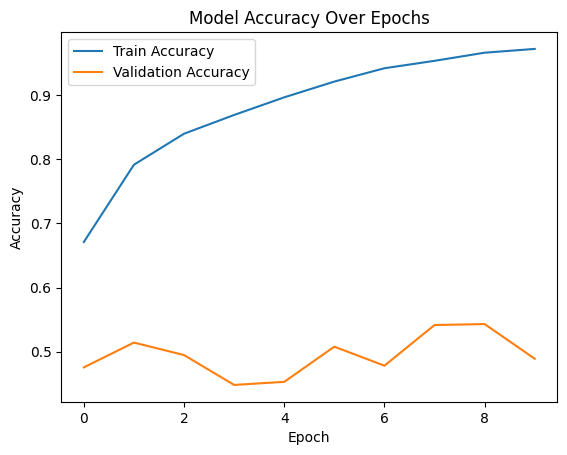

In [ ]:
import matplotlib.pyplot as plt

# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()


Train files sample: ['/kaggle/input/dogs-vs-cats/train/train/cat.12461.jpg', '/kaggle/input/dogs-vs-cats/train/train/dog.3443.jpg', '/kaggle/input/dogs-vs-cats/train/train/dog.7971.jpg', '/kaggle/input/dogs-vs-cats/train/train/dog.10728.jpg', '/kaggle/input/dogs-vs-cats/train/train/dog.1942.jpg']
Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 917s 1s/step - accuracy: 0.6001 - loss: 0.6525 - val_accuracy: 0.6127 - val_loss: 0.8795
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 939s 1s/step - accuracy: 0.7816 - loss: 0.4708 - val_accuracy: 0.4222 - val_loss: 1.7588


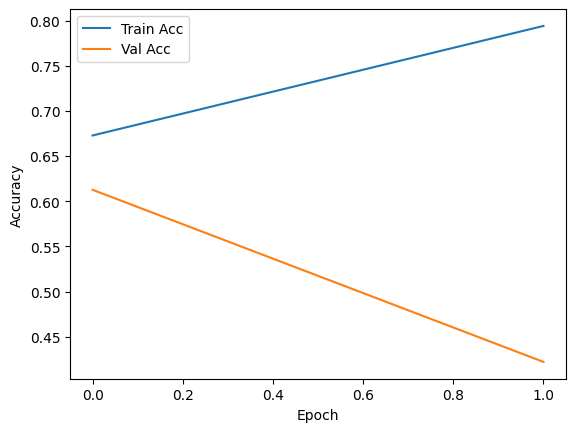

In [4]:
import tensorflow as tf
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

# Paths
train_dir = '/kaggle/input/dogs-vs-cats/train/train'
test_dir = '/kaggle/input/dogs-vs-cats/test/test'

# Get filepaths to check
train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
print("Train files sample:", train_files[:5])

# Function to get label from filename
def get_label(file_path):
    filename = tf.strings.split(file_path, os.sep)[-1]
    label = tf.strings.split(filename, '.')[0]
    # Debug: print label
    # tf.print("Filename:", filename, "Label:", label)
    return tf.cast(tf.equal(label, 'dog'), tf.int32)  # dog=1, cat=0

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128,128])
    img = img / 255.0
    return img, label

# Build datasets
train_list = tf.data.Dataset.list_files(train_dir + '/*.jpg')
train_ds = train_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_list = tf.data.Dataset.list_files(test_dir + '/*.jpg')
val_ds = val_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit and store history
history = model.fit(train_ds, validation_data=val_ds, epochs=2)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
